In [20]:
import pandas as pd
from collections import Counter
from tqdm import tqdm
import numpy as np
from sklearn import metrics
from numpy import vstack,array
from numpy.random import rand
from itertools import combinations
import networkx as nx
import contextily as ctx
from mpl_toolkits.basemap import Basemap as Basemap
from os import walk
import matplotlib.pyplot as plt 
import matplotlib.image as mgimg
from grave import plot_network

## Reading the dataset

In [41]:
clusters = pd.read_csv('./dataset/clusters.csv')

entries = pd.read_csv('./dataset/cluster_conenctions.csv')
datapoints = pd.read_csv('./dataset/dataset_with_users_and_clusters.csv')

## Building the graph

In [42]:
N = 4 # Connetion identification threshold
G = get_graph(N)

## Plot the graph

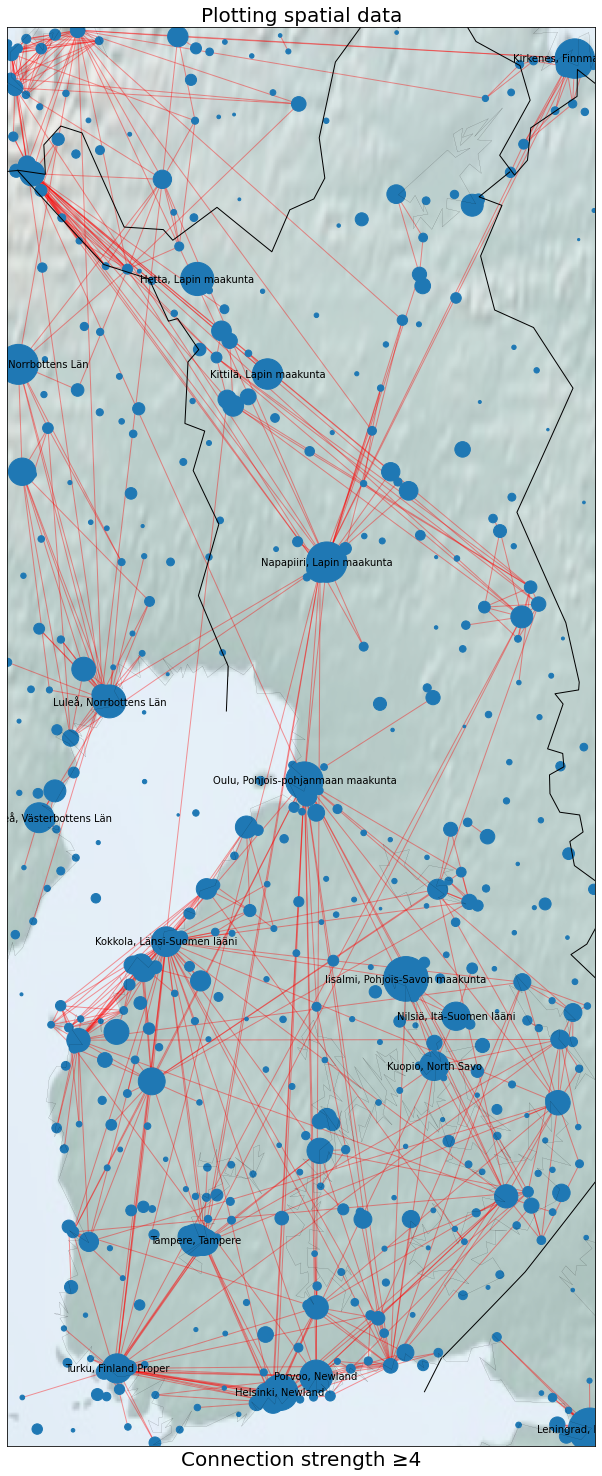

In [43]:
edge_color = 'r'
edge_alpha = 0.4
plot_map(G, N, edge_color, edge_alpha)

In [27]:
def get_graph(n_conn):
    clusters = pd.read_csv('./dataset/clusters.csv')
    clusters.index.name = 'cluster_id'
    entries = pd.read_csv('./dataset/cluster_conenctions.csv')
    G = nx.Graph()
    for c in clusters.iterrows():
        G.add_node(c[0], pos=(c[1]['lon'], c[1]['lat']), label=c[1]['label'], size=c[1]['size'])
    for row in entries.iterrows():
        if row[1]['entries'] > n_conn: # gathering is considered to be more than 2 people
            G.add_edge(row[1]['cluster_id0'],
                   row[1]['cluster_id1'],
                   weight=row[1]['entries'])
    return G

In [29]:
def plot_map(G, n_conn, edge_color, edge_alpha, should_save=False):
    min_lat = 59.800
    max_lat = 69.910
    min_lon = 20.410
    max_lon = 30.410

    fig, ax = plt.subplots(figsize = (10,20))
    m = Basemap(
         projection='merc',
         llcrnrlon=min_lon,
         llcrnrlat=min_lat,
         urcrnrlon=max_lon,
         urcrnrlat=max_lat,
         lat_ts=0,
         resolution='l',
         suppress_ticks=True)

    pos_data = nx.get_node_attributes(G, 'pos')
    lons = clusters['lon'].values
    lats = clusters['lat'].values
    pos = {}
    # convert lat and lon to map projection
    mx, my = m(lons, lats)
    for count, value in enumerate(pos_data.items()):
        pos[count] = (mx[count], my[count])
    
    
    labels_all = nx.get_node_attributes(G, 'label')
    labels = {}
    for x in G.nodes():
        if nx.get_node_attributes(G, 'size')[x] >= 800:
            labels[x] = labels_all[x]
        
    node_sizes=list(nx.get_node_attributes(G, 'size').values())
    nx.draw_networkx_nodes(G, pos = pos, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos = pos, alpha=edge_alpha, edge_color=edge_color)
    nx.draw_networkx_labels(G, pos, labels = labels, font_size=10)

    m.drawcountries(linewidth = 1)
    m.shadedrelief(alpha=0.6)
    m.drawcoastlines(linewidth=0.1)
    plt.tight_layout()
    plt.title('Plotting spatial data', fontsize=20)
    ax.set_xlabel('Connection strength ≥' + str(n_conn), fontsize=20)
    if should_save:
        fig.savefig('./maps/map_conn_' + str(n_conn) + '.png')
    plt.show()